In [1]:
%matplotlib inline


# Cascade decomposition

This example script shows how to compute and plot the cascade decompositon of 
a single radar precipitation field in pysteps.


In [2]:
from matplotlib import cm, pyplot as plt
import numpy as np
import os
from pprint import pprint
from pysteps.cascade.bandpass_filters import filter_gaussian
from pysteps import io, rcparams
from pysteps.cascade.decomposition import decomposition_fft
from pysteps.utils import conversion, transformation
from pysteps.visualization import plot_precip_field

Pysteps configuration file found at: /home/runner/.pysteps/pystepsrc



## Read precipitation field

First thing,  the radar composite is imported and transformed in units
of dB.



{'accutime': 5.0,
 'cartesian_unit': 'm',
 'institution': 'Finnish Meteorological Institute',
 'projection': '+proj=stere  +lon_0=25E +lat_0=90N +lat_ts=60 +a=6371288 '
               '+x_0=380886.310 +y_0=3395677.920 +no_defs',
 'threshold': 0.0002548805471873859,
 'transform': None,
 'unit': 'mm/h',
 'x1': 0.0049823258887045085,
 'x2': 759752.2852757066,
 'xpixelsize': 999.674053,
 'y1': 0.009731985162943602,
 'y2': 1225544.6588913496,
 'yorigin': 'upper',
 'ypixelsize': 999.62859,
 'zerovalue': 0.0,
 'zr_a': 223.0,
 'zr_b': 1.53}


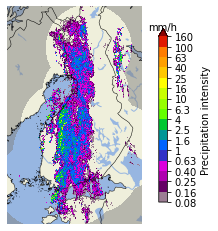

In [3]:
# Import the example radar composite
root_path = rcparams.data_sources["fmi"]["root_path"]
filename = os.path.join(
    root_path, "20160928", "201609281600_fmi.radar.composite.lowest_FIN_SUOMI1.pgm.gz"
)
R, _, metadata = io.import_fmi_pgm(filename, gzipped=True)

# Convert to rain rate
R, metadata = conversion.to_rainrate(R, metadata)

# Nicely print the metadata
pprint(metadata)

# Plot the rainfall field
plot_precip_field(R, geodata=metadata)
plt.show()

# Log-transform the data
R, metadata = transformation.dB_transform(R, metadata, threshold=0.1, zerovalue=-15.0)

## 2D Fourier spectrum

Compute and plot the 2D Fourier power spectrum of the precipitaton field.



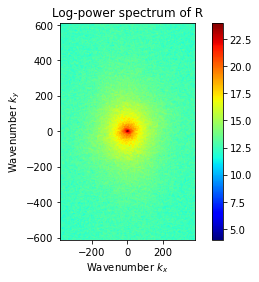

In [4]:
# Set Nans as the fill value
R[~np.isfinite(R)] = metadata["zerovalue"]

# Compute the Fourier transform of the input field
F = abs(np.fft.fftshift(np.fft.fft2(R)))

# Plot the power spectrum
M, N = F.shape
fig, ax = plt.subplots()
im = ax.imshow(
    np.log(F ** 2), vmin=4, vmax=24, cmap=cm.jet, extent=(-N / 2, N / 2, -M / 2, M / 2)
)
cb = fig.colorbar(im)
ax.set_xlabel("Wavenumber $k_x$")
ax.set_ylabel("Wavenumber $k_y$")
ax.set_title("Log-power spectrum of R")
plt.show()

## Cascade decomposition

First, construct a set of Gaussian bandpass filters and plot the corresponding
1D filters.



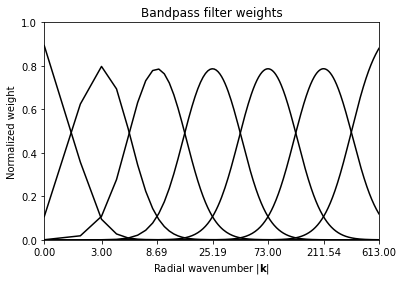

In [5]:
num_cascade_levels = 7

# Construct the Gaussian bandpass filters
filter = filter_gaussian(R.shape, num_cascade_levels)

# Plot the bandpass filter weights
L = max(N, M)
fig, ax = plt.subplots()
for k in range(num_cascade_levels):
    ax.semilogx(
        np.linspace(0, L / 2, len(filter["weights_1d"][k, :])),
        filter["weights_1d"][k, :],
        "k-",
        base=pow(0.5 * L / 3, 1.0 / (num_cascade_levels - 2)),
    )
ax.set_xlim(1, L / 2)
ax.set_ylim(0, 1)
xt = np.hstack([[1.0], filter["central_wavenumbers"][1:]])
ax.set_xticks(xt)
ax.set_xticklabels(["%.2f" % cf for cf in filter["central_wavenumbers"]])
ax.set_xlabel("Radial wavenumber $|\mathbf{k}|$")
ax.set_ylabel("Normalized weight")
ax.set_title("Bandpass filter weights")
plt.show()

Finally, apply the 2D Gaussian filters to decompose the radar rainfall field
into a set of cascade levels of decreasing spatial scale and plot them.



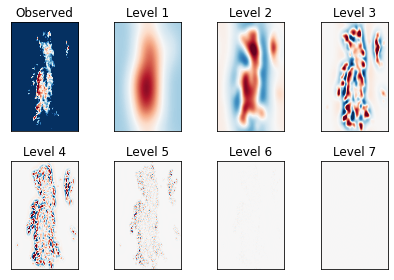

In [6]:
decomp = decomposition_fft(R, filter, compute_stats=True)

# Plot the normalized cascade levels
for i in range(num_cascade_levels):
    mu = decomp["means"][i]
    sigma = decomp["stds"][i]
    decomp["cascade_levels"][i] = (decomp["cascade_levels"][i] - mu) / sigma

fig, ax = plt.subplots(nrows=2, ncols=4)

ax[0, 0].imshow(R, cmap=cm.RdBu_r, vmin=-5, vmax=5)
ax[0, 1].imshow(decomp["cascade_levels"][0], cmap=cm.RdBu_r, vmin=-3, vmax=3)
ax[0, 2].imshow(decomp["cascade_levels"][1], cmap=cm.RdBu_r, vmin=-3, vmax=3)
ax[0, 3].imshow(decomp["cascade_levels"][2], cmap=cm.RdBu_r, vmin=-3, vmax=3)
ax[1, 0].imshow(decomp["cascade_levels"][3], cmap=cm.RdBu_r, vmin=-3, vmax=3)
ax[1, 1].imshow(decomp["cascade_levels"][4], cmap=cm.RdBu_r, vmin=-3, vmax=3)
ax[1, 2].imshow(decomp["cascade_levels"][5], cmap=cm.RdBu_r, vmin=-3, vmax=3)
ax[1, 3].imshow(decomp["cascade_levels"][6], cmap=cm.RdBu_r, vmin=-3, vmax=3)

ax[0, 0].set_title("Observed")
ax[0, 1].set_title("Level 1")
ax[0, 2].set_title("Level 2")
ax[0, 3].set_title("Level 3")
ax[1, 0].set_title("Level 4")
ax[1, 1].set_title("Level 5")
ax[1, 2].set_title("Level 6")
ax[1, 3].set_title("Level 7")

for i in range(2):
    for j in range(4):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
plt.tight_layout()
plt.show()

# sphinx_gallery_thumbnail_number = 4